### Set paths and Import libraries 

In [ ]:
import os
import sys
import time 
import pickle
# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
csvpath = '~/code/nn_orthoreplay/' #  path to the csv files


import numpy as np
import pdb
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm  # Import cm for colormap functionality
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from scipy.stats import pearsonr
# Import helper functions from stateformation_get_input_output.py:
from stateformation_get_input_output_passive_block import get_input_output_stateformation
from stateformation_get_input_output_passive_block import get_active_trials_input_comb
from stateformation_get_input_output_passive_block import rewardfun
from stateformation_get_input_output_passive_block import input2state

# which subjects to use (set to subset to increase speed ...)
subjs = ['sub503','sub504', 'sub505', 'sub506', 'sub507', 'sub508', 'sub509', 'sub510',
 'sub511', 'sub512', 'sub513', 'sub514', 'sub515', 'sub516', 'sub517', 'sub518', 'sub519', 'sub521', 'sub522', 'sub523', 'sub524', 'sub525', 'sub526', 'sub527', 'sub528', 'sub529', 'sub530', 
  'sub531', 'sub532', 'sub533', 'sub534', 'sub535', 'sub536', 'sub537', 'sub538', 'sub539', 'sub540', 
  'sub541', 'sub542', 'sub543', 'sub544', 'sub545', 'sub546', 'sub547', 'sub548', 'sub549', 'sub550', 
  'sub551', 'sub552', 'sub553', 'sub554', 'sub555', 'sub556', 'sub557', 'sub558', 'sub559', 'sub560', 
  'sub561', 'sub562', 'sub563', 'sub564']

allsubjs = ['sub501', 'sub502', 'sub503', 'sub504', 'sub505', 'sub506', 'sub507', 'sub508', 'sub509', 'sub510',
 'sub511', 'sub512', 'sub513', 'sub514', 'sub515', 'sub516', 'sub517', 'sub518', 'sub519', 
  'sub521', 'sub522', 'sub523', 'sub524', 'sub525', 'sub526', 'sub527', 'sub528', 'sub529', 'sub530', 
  'sub531', 'sub532', 'sub533', 'sub534', 'sub535', 'sub536', 'sub537', 'sub538', 'sub539', 'sub540', 
  'sub541', 'sub542', 'sub543', 'sub544', 'sub545', 'sub546', 'sub547', 'sub548', 'sub549', 'sub550', 
  'sub551', 'sub552', 'sub553', 'sub554', 'sub555', 'sub556', 'sub557', 'sub558', 'sub559', 'sub560', 
  'sub561', 'sub562', 'sub563', 'sub564'] 

n_blocks = 11
n_trials = 462 # 
n_passive_trials = 198
n_active_trials = 264 # 
blocksize = 42
n_subj = len(subjs)
stepidx = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # First row
    [0, 1, 2, 3, 10, 11, 12, 13, 14, 15]  # Second row
])
all_states = ['a1_l', 'a2_l', 'a3_l', 'a4_l', 'b1_l', 'b2_l', 'b3_l', 'b4_l']


### Define Custom functions for averaging etc 

In [7]:
# Function to compute running average
def running_average(data, window_size):
    kernel = np.ones(window_size) / window_size
    if data.ndim == 1:  # For 1D arrays
        return np.convolve(data, kernel, mode='valid')
    elif data.ndim == 2:  # For 2D arrays
        return np.array([np.convolve(row, kernel, mode='valid') for row in data])
    else:
        raise ValueError("Input data must be 1D or 2D.")

# Function to compute marginal means
def prep_marginal_means(cdim, loss_array, acc_array, window_size=15):
    """
    Compute running averages for loss and accuracy based on the specified dimension (cdim).

    Args:
        cdim (int): The dimension to marginalize over (0 for learning rates, 1 for RNN gains, 2 for FC gains).
        loss_array (np.ndarray): The array of losses with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        acc_array (np.ndarray): The array of accuracies with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        window_size (int): The window size for the running average.

    Returns:
        running_avg_loss (np.ndarray): Running averages of losses.
        running_avg_accuracy (np.ndarray): Running averages of accuracies.
    """
    axes = tuple({0, 1, 2, 3} - {cdim})
    cmeanloss = np.mean(loss_array, axis=axes)  # Mean over marginalized dimensions
    cmeanacc = np.mean(acc_array, axis=axes)  # Mean over marginalized dimensions
    running_avg_loss = running_average(cmeanloss, window_size=window_size)
    running_avg_accuracy = running_average(cmeanacc, window_size=window_size)
    dimsize = running_avg_loss.shape[0]
    return running_avg_loss, running_avg_accuracy, dimsize

def prepare_data(sub, csvpath, isRecurrent=True, withPassive = True, input_norm = True):
    # Load the data using the provided helper function
    inputs, targets, isPassive, states,  block, passive_type, responses, correct_responses = get_input_output_stateformation(sub=sub,csvpath = csvpath, isRecurrent=isRecurrent, withPassive = withPassive)   
    #inputs, targets = get_input_output_stateformation(sub=sub, csvpath=csvpath, isRecurrent=isRecurrent)
    if input_norm: 
        mean = inputs.mean(axis=-1, keepdims=True)  # shape: (462, 2, 1)
        std = inputs.std(axis=-1, keepdims=True)    # shape: (462, 2, 1)
        # Normalize
        inputs_norm = (inputs - mean) / (std + 1e-8)     # shape: (462, 2, 16)
        # Transform inputs
        inputs = np.transpose(inputs_norm, (1, 2, 0))  # Rearrange dimensions -- use NORMED
    else: 
        inputs = np.transpose(inputs, (1, 2, 0))  # Rearrange dimensions -- use UN NORMED
    
    inputs = inputs[np.newaxis, :, :, :]  # Add a new axis for batch size
    passive_inputs = inputs[:,:,:,isPassive == 1]  # Inputs where isPassive is True
    active_inputs = inputs[:,:,:,isPassive == 0]  # Inputs where isPassive is False

    inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_inputs = torch.tensor(passive_inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    active_inputs = torch.tensor(active_inputs, dtype=torch.float32)  # Convert to PyTorch tensor

    # Transform targets
    targets = np.transpose(targets, (1, 0))  # Rearrange dimensions
    targets = targets[np.newaxis, :, :]  # Add a new axis for batch size
    passive_targets = targets[:,:,isPassive == 1]  # targets where isPassive is True
    active_targets = targets[:,:,isPassive == 0]  # targets where isPassive is False
    
    targets = torch.tensor(targets, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_targets = torch.tensor(passive_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    active_targets = torch.tensor(active_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    
    return inputs, active_inputs, passive_inputs, targets, active_targets, passive_targets, states, isPassive, block, passive_type, responses, correct_responses

def get_pair_indices(states, passive_idx, blocksize = 42, nblocks = 11):
    earlypre_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    earlypost_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    latepre_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    latepost_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    latepre_repeat_sort_matrix = np.zeros((nblocks, 1), dtype=int)
    latepost_repeat_sort_matrix = np.zeros((nblocks, 1), dtype=int)


    for cblock in range(nblocks):
        # Get the indices ands states for the early pre and post states
        earlypreidx = cblock*blocksize + np.arange(0,4)
        earlypostidx = cblock*blocksize + np.arange(8,12)
        cstates_earlypre = states[earlypreidx.astype(int)]
        cstates_earlypost = states[earlypostidx.astype(int)]
        
        # Get the indices and states for the late pre and post states
        latepreidx = cblock*blocksize + np.arange(28,33)
        latepostidx = cblock*blocksize + np.arange(37,42)
        cstates_latepre = states[latepreidx.astype(int)]
        cstates_latepost = states[latepostidx.astype(int)]

        # Get the indices and states for the late between states
        latebetweenidx = cblock*blocksize + np.arange(33, 37)
        cstates_latebetween = states[latebetweenidx.astype(int)]

        # Check for overlap between late pre/post states and late between states
        latepre_prefixes = np.array([state[:2] for state in cstates_latepre])
        latepost_prefixes = np.array([state[:2] for state in cstates_latepost])
        latebetween_1 = np.array([state[:2] for state in cstates_latebetween])
        latebetween_2 = np.array([state[2:] for state in cstates_latebetween])

        overlap_pre1 = np.isin(latepre_prefixes, latebetween_1)
        overlap_pre2 = np.isin(latepre_prefixes, latebetween_2)
        overlap_pre = overlap_pre1 | overlap_pre2
        overlap_post1 = np.isin(latepost_prefixes, latebetween_1)
        overlap_post2 = np.isin(latepost_prefixes, latebetween_2)
        overlap_post = overlap_post1 | overlap_post2
        
        # get the repeat indices 
        lateprerepeatidx = latepreidx[np.where(overlap_pre)[0].astype(int)]
        latepostrepeatidx = latepostidx[np.where(overlap_post)[0].astype(int)]
        
        # Remove the late states that overlap with the latebetween states
        cstates_latepre = cstates_latepre[~overlap_pre]
        latepreidx = latepreidx[~overlap_pre]
        cstates_latepost = cstates_latepost[~overlap_post]
        latepostidx = latepostidx[~overlap_post]

        # sort the pre states 
        earlypre_sort_matrix[cblock,:] = earlypreidx[np.argsort(cstates_earlypre)].astype(int)
        earlypre_sort_matrix[cblock,:] = np.searchsorted(passive_idx, earlypre_sort_matrix[cblock,:])
        latepre_sort_matrix[cblock,:] = latepreidx[np.argsort(cstates_latepre)].astype(int)
        latepre_sort_matrix[cblock,:] = np.searchsorted(passive_idx, latepre_sort_matrix[cblock,:])
        latepre_repeat_sort_matrix[cblock,:] = lateprerepeatidx
        latepre_repeat_sort_matrix[cblock,:] = np.searchsorted(passive_idx, latepre_repeat_sort_matrix[cblock,:])
        # sort the post states to match the sorted pre states 
        earlypost_sort_matrix[cblock,:] = earlypostidx[np.argsort(cstates_earlypost)].astype(int)
        earlypost_sort_matrix[cblock,:] = np.searchsorted(passive_idx, earlypost_sort_matrix[cblock,:])
        latepost_sort_matrix[cblock,:] = latepostidx[np.argsort(cstates_latepost)].astype(int)
        latepost_sort_matrix[cblock,:] = np.searchsorted(passive_idx, latepost_sort_matrix[cblock,:])
        latepost_repeat_sort_matrix[cblock,:] = latepostrepeatidx
        latepost_repeat_sort_matrix[cblock,:] = np.searchsorted(passive_idx, latepost_repeat_sort_matrix[cblock,:])
    
    return earlypre_sort_matrix, earlypost_sort_matrix, latepre_sort_matrix, latepost_sort_matrix, latepre_repeat_sort_matrix, latepost_repeat_sort_matrix

# weight initialization function
def initialize_weights_old(module, rnn_gain=1.0, fc_gain=1.0):
    if isinstance(module, nn.RNN):  # For recurrent layers
        for name, param in module.named_parameters():
            if 'weight' in name:
                init.torch.nn.init.xavier_normal_(param, gain = rnn_gain)  # Uniform initialization with SD for RNN
            elif 'bias' in name:
                init.zeros_(param)  # Initialize biases to zero
    elif isinstance(module, nn.Linear):  # For fully connected layers
        init.torch.nn.init.xavier_normal_(module.weight, gain = fc_gain)  # Uniform initialization with SD for FC
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize biases to zero

def initialize_weights(module, rnn_gain=1.0, fc_gain=1.0, weight_init='xavier_normal', rnn_nonlinearity='relu', fc_nonlinearity='relu'):
    def get_init_fn(weight_init, nonlinearity):
        if weight_init == 'xavier_normal':
            return lambda w, gain: init.xavier_normal_(w, gain=gain)
        elif weight_init == 'xavier_uniform':
            return lambda w, gain: init.xavier_uniform_(w, gain=gain)
        elif weight_init == 'kaiming_normal':
            return lambda w, gain: init.kaiming_normal_(w, nonlinearity=nonlinearity)
        elif weight_init == 'kaiming_uniform':
            return lambda w, gain: init.kaiming_uniform_(w, nonlinearity=nonlinearity)
        elif weight_init == 'normal':
            return lambda w, gain: init.normal_(w, mean=0.0, std=gain)
        elif weight_init == 'uniform':
            return lambda w, gain: init.uniform_(w, a=-gain, b=gain)
        else:
            raise ValueError(f"Unknown weight_init: {weight_init}")

    rnn_init_fn = get_init_fn(weight_init, rnn_nonlinearity)
    fc_init_fn = get_init_fn(weight_init, fc_nonlinearity)

    if isinstance(module, nn.RNN):
        for name, param in module.named_parameters():
            if 'weight' in name:
                rnn_init_fn(param, rnn_gain)
            elif 'bias' in name:
                init.zeros_(param)
    elif isinstance(module, nn.Linear):
        fc_init_fn(module.weight, fc_gain)
        if module.bias is not None:
            init.zeros_(module.bias)

def get_avg_input_weights(model):
    """Return the mean of the absolute values of the input weights for each input unit."""
    # rnn.weight_ih_l0 shape: (hidden_rnn_dim, input_dim)
    weight_ih = model.rnn.weight_ih_l0.detach().cpu()  # shape [hidden_rnn_dim, input_dim]
    # Average across hidden units, per input unit
    avg_weights = weight_ih.mean(dim=0)  # shape: [input_dim]
    return avg_weights

def compute_state_corr_mat(netreps, states, passive_idx, all_states, n_blocks=11, blocksize=42):
    """
    Compute state correlation matrix for neural representations.
    
    Args:
        netreps: Neural representations array, shape (n_passive_trials, n_features)
        states: Array of state labels for all trials
        passive_idx: Indices of passive trials
        all_states: List of all possible states (e.g., ['a1_l', 'a2_l', 'a3_l', 'a4_l', 'b1_l', 'b2_l', 'b3_l', 'b4_l'])
        n_blocks: Number of blocks (default: 11)
        blocksize: Number of trials per block (default: 42)
    
    Returns:
        state_corr_mat: Correlation matrix, shape (len(all_states), len(all_states), n_blocks)
    """
    n_states = len(all_states)
    state_corr_mat = np.full((n_states, n_states, n_blocks), np.nan)
    
    for cblock in range(n_blocks):
        ctrials = np.arange(cblock * blocksize, (cblock + 1) * blocksize)  
        for ct1, cstate1 in enumerate(all_states):
            # Find indices for state1 in current block
            cstatevec = np.where(states == cstate1)[0]
            cidx1 = cstatevec[np.isin(cstatevec, ctrials)]
            cidx1 = np.where(np.isin(passive_idx, cidx1))[0]
            
            if len(cidx1) == 0:
                continue
                
            # Get mean representation for state1
            A = np.nanmean(netreps[cidx1, :], axis=0)
            
            for ct2, cstate2 in enumerate(all_states):
                # Find indices for state2 in current block
                cstatevec = np.where(states == cstate2)[0]
                cidx2 = cstatevec[np.isin(cstatevec, ctrials)]
                cidx2 = np.where(np.isin(passive_idx, cidx2))[0]
                
                if len(cidx2) == 0:
                    continue
                    
                # Get mean representation for state2
                B = np.nanmean(netreps[cidx2, :], axis=0)
                
                # Compute correlation
                if not (np.isnan(A).any() or np.isnan(B).any()):
                    state_corr_mat[ct1, ct2, cblock] = np.corrcoef(A, B)[0, 1]
    
    return state_corr_mat


### Define Network class (determines architecture)

In [8]:
# Define network
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_rnn_dim, hidden_fc_dim, output_dim, hidden_rnn_activation, hidden_fc_activation, output_activation, layer_norm = False):
        super(SimpleRNN, self).__init__()
        # Recurrent hidden layer
        self.rnn = nn.RNN(input_dim, hidden_rnn_dim, nonlinearity=hidden_rnn_activation, bias=True, batch_first=True)
        # Fully connected hidden layer
        self.fc_hidden = nn.Linear(hidden_rnn_dim, hidden_fc_dim, bias=True)
        # Output layer
        self.output = nn.Linear(hidden_fc_dim, output_dim, bias=True)
        
        # layer normalisations 
        self.norm_rnn = nn.LayerNorm(hidden_rnn_dim)
        self.norm_fc = nn.LayerNorm(hidden_fc_dim)
       
        # Dynamically set the activation function for the fully connected hidden layer
        if hidden_fc_activation == 'relu':
            self.hidden_activation = nn.ReLU()
        elif hidden_fc_activation == 'tanh':
            self.hidden_activation = nn.Tanh()
        elif hidden_fc_activation == 'sigmoid':
            self.hidden_activation = nn.Sigmoid()
        elif hidden_fc_activation == 'linear':
            self.hidden_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {hidden_fc_activation}")
        
        # Dynamically set the activation function for the output layer
        if output_activation == 'relu':
            self.output_activation = nn.ReLU()
        elif output_activation == 'tanh':
            self.output_activation = nn.Tanh()
        elif output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation == 'softmax':
            self.output_activation = nn.Softmax(dim=1)  # Softmax for classification
        elif output_activation == 'linear':
            self.output_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {output_activation}")

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # x should have shape (batch_size, n_steps, input_dim)
        # Take the output of the last time step
        rnn_last_out = rnn_out[:, -1, :]  # Shape: (batch_size, hidden_rnn_dim)
        # Normalize after RNN
        if layer_norm:
            normed_rnn_last_out = self.norm_rnn(rnn_last_out)
            fc_hidden = self.fc_hidden(normed_rnn_last_out)
            normed_fc_hidden = self.norm_fc(fc_hidden)
            fc_hidden_out = self.hidden_activation(normed_fc_hidden)
        else: 
            fc_hidden = self.fc_hidden(rnn_last_out)
            fc_hidden_out = self.hidden_activation(fc_hidden)
        
        output = self.output(fc_hidden_out)
        output_out = self.output_activation(output)

        return output_out, rnn_last_out, fc_hidden_out



### Basic Network Settings 

In [13]:
hidden_rnn_activation = 'relu'
hidden_fc_activation = 'relu'
output_activation = 'linear' 
weight_init = 'xavier_normal'  # Options: 'xavier_normal', 'xavier_uniform', 'kaiming_normal', 'kaiming_uniform', 'normal', 'uniform'
layer_norm = False 
input_norm = False
momentum = 0.75  # Momentum for SGD
win_size = 30
learning_rates = np.linspace(0.001, 0.15, 9); 
rnn_gains = np.linspace(0.01, 3, 9); #np.arange(0.1, 2 + 0.001, 1/3) 
fc_gains = np.linspace(0.01, 3, 9); #np.arange(0.1, 2 + 0.001, 1/3) 
n_lr = len(learning_rates)
n_rg = len(rnn_gains)
n_fg = len(fc_gains)
n_iter = 9

# network shape parameters
output_dim = 1
batch_size = 1
n_steps = 2
input_dim = 10
hidden_fan_factor = 4
hidden_rnn_dim = input_dim*hidden_fan_factor
hidden_fc_dim = input_dim*hidden_fan_factor

# Preallocate the results structure
choiceacc_array = np.full((n_subj, n_active_trials), np.nan)
loss_array = np.full((n_lr, n_rg, n_fg, n_subj, n_active_trials), np.nan)
acc_array = loss_array.copy()  # Create a copy of loss_array for accuracies
rewards_array = loss_array.copy()  # Create a copy of loss_array for accuracies
pes_array = loss_array.copy()  # Create a copy of loss_array for accuracies
nll_array = loss_array.copy()  # Create a copy of loss_array for probabilities 
weights_array = np.full((n_lr, n_rg, n_fg, n_subj, 10, n_active_trials), np.nan)  # Preallocate weights array
best_subj_net = np.full((3, n_subj), -1)
net_perf = np.full((n_subj, 235), np.nan)  # Preallocate net performance array
subj_perf = np.full((n_subj, 235), np.nan)  # Preallocate net performance array
subj_weights = np.full((n_subj, 10, n_active_trials), np.nan)  # Preallocate subject weights array
state_corr_rnn_all = np.full((8, 8, n_blocks, n_subj), np.nan)
state_corr_fc_all = np.full((8, 8, n_blocks, n_subj), np.nan)
input_corr_all = np.full((8, 8, n_blocks, n_subj), np.nan)

passive_rnn_last_outs = np.zeros((n_passive_trials, hidden_rnn_dim, n_lr, n_rg, n_fg, n_subj))  # Preallocate array
passive_fc_hidden_outs = np.zeros((n_passive_trials, hidden_fc_dim, n_lr, n_rg, n_fg, n_subj))  # Preallocate array
passive_inputs_outs = np.zeros((n_steps, input_dim, n_passive_trials, n_subj))  # Preallocate array

response_mapping = {'left': 0, 'right': 1, np.nan: -1}  # Use -1 for NaN as an integer placeholder

print(f"""
Experiment Configuration:
========================
Learning Rates:    {n_lr:>3}
RNN Gains:         {n_rg:>3}
FC Gains:          {n_fg:>3}
Iterations:        {n_iter:>3}
------------------------
Total Iterations:  {n_lr*n_rg*n_fg*n_iter:>3}
""")



Experiment Configuration:
Learning Rates:      9
RNN Gains:           9
FC Gains:            9
Iterations:          9
------------------------
Total Iterations:  6561



*** Starting subject 1/61 (sub503) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 80.20 min |Max net perf: 0.88 | min LS: 0.57 | best fit: 0.020, 1.879, 0.758


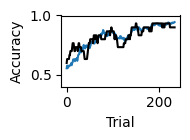

*** Starting subject 2/61 (sub504) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.40 min |Max net perf: 0.88 | min LS: 2.44 | best fit: 0.094, 0.384, 1.505


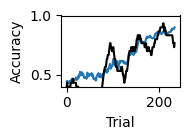

*** Starting subject 3/61 (sub505) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.41 min |Max net perf: 0.88 | min LS: 1.14 | best fit: 0.020, 1.879, 0.384


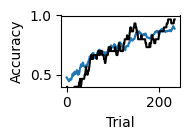

*** Starting subject 4/61 (sub506) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.38 min |Max net perf: 0.89 | min LS: 2.24 | best fit: 0.038, 2.252, 1.131


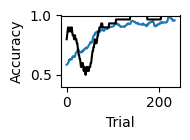

*** Starting subject 5/61 (sub507) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.87 | min LS: 2.29 | best fit: 0.075, 3.000, 0.758


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


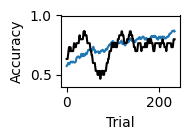

*** Starting subject 6/61 (sub508) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.34 min |Max net perf: 0.88 | min LS: 3.03 | best fit: 0.094, 2.252, 0.384


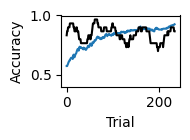

*** Starting subject 7/61 (sub509) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.40 min |Max net perf: 0.85 | min LS: 0.85 | best fit: 0.075, 1.131, 0.758


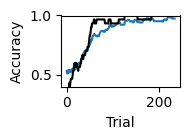

*** Starting subject 8/61 (sub510) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.85 | min LS: 1.27 | best fit: 0.075, 2.626, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


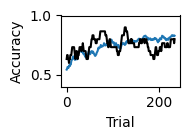

*** Starting subject 9/61 (sub511) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.86 | min LS: 0.73 | best fit: 0.038, 2.252, 0.758


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


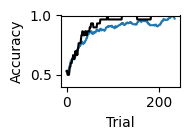

*** Starting subject 10/61 (sub512) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.34 min |Max net perf: 0.88 | min LS: 1.36 | best fit: 0.038, 1.505, 1.131


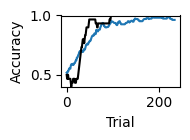

*** Starting subject 11/61 (sub513) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.34 min |Max net perf: 0.88 | min LS: 0.83 | best fit: 0.113, 1.131, 1.131


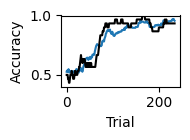

*** Starting subject 12/61 (sub514) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.87 | min LS: 0.86 | best fit: 0.150, 1.505, 0.758


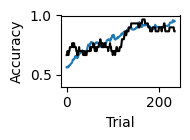

*** Starting subject 13/61 (sub515) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 255.36 min |

/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Max net perf: 0.88 | min LS: 1.71 | best fit: 0.131, 1.131, 1.879


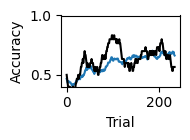

*** Starting subject 14/61 (sub516) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.43 min |Max net perf: 0.86 | min LS: 1.21 | best fit: 0.094, 1.879, 0.758


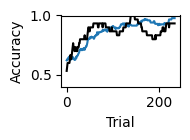

*** Starting subject 15/61 (sub517) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.36 min |Max net perf: 0.88 | min LS: 0.54 | best fit: 0.020, 1.879, 1.131


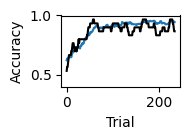

*** Starting subject 16/61 (sub518) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.36 min |Max net perf: 0.89 | min LS: 1.94 | best fit: 0.113, 1.505, 1.879


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


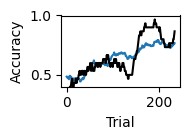

*** Starting subject 17/61 (sub519) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.43 min |Max net perf: 0.88 | min LS: 1.43 | best fit: 0.020, 3.000, 1.131


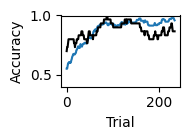

*** Starting subject 18/61 (sub521) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.42 min |Max net perf: 0.88 | min LS: 1.81 | best fit: 0.038, 2.252, 0.758


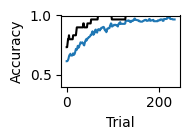

*** Starting subject 19/61 (sub522) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.45 min |Max net perf: 0.87 | min LS: 1.36 | best fit: 0.038, 3.000, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


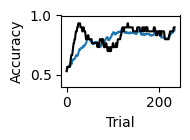

*** Starting subject 20/61 (sub523) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.38 min |Max net perf: 0.86 | min LS: 1.63 | best fit: 0.057, 3.000, 0.758


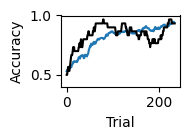

*** Starting subject 21/61 (sub524) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.32 min |Max net perf: 0.88 | min LS: 1.13 | best fit: 0.057, 2.252, 1.131


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


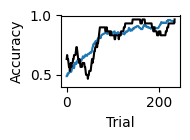

*** Starting subject 22/61 (sub525) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.28 min |Max net perf: 0.89 | min LS: 1.58 | best fit: 0.094, 3.000, 0.384


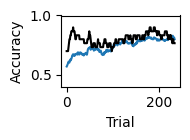

*** Starting subject 23/61 (sub526) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.32 min |

/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Max net perf: 0.87 | min LS: 0.84 | best fit: 0.038, 0.758, 2.626


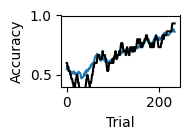

*** Starting subject 24/61 (sub527) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.26 min |Max net perf: 0.88 | min LS: 1.93 | best fit: 0.057, 2.252, 0.384


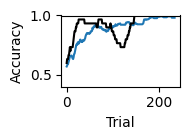

*** Starting subject 25/61 (sub528) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.88 | min LS: 0.49 | best fit: 0.057, 1.505, 0.758


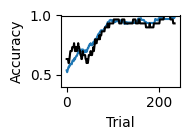

*** Starting subject 26/61 (sub529) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.28 min |Max net perf: 0.89 | min LS: 0.44 | best fit: 0.038, 3.000, 1.131


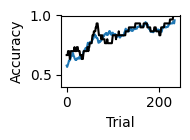

*** Starting subject 27/61 (sub530) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.33 min |Max net perf: 0.87 | min LS: 1.85 | best fit: 0.020, 2.626, 0.758


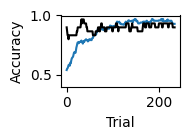

*** Starting subject 28/61 (sub531) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.46 min |Max net perf: 0.88 | min LS: 1.08 | best fit: 0.150, 2.252, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


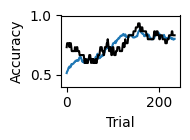

*** Starting subject 29/61 (sub532) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.45 min |Max net perf: 0.85 | min LS: 1.23 | best fit: 0.038, 3.000, 0.758


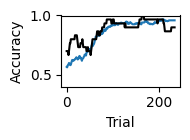

*** Starting subject 30/61 (sub533) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.26 min |Max net perf: 0.89 | min LS: 0.50 | best fit: 0.113, 0.384, 0.758


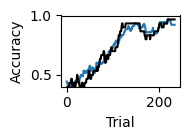

*** Starting subject 31/61 (sub534) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.87 | min LS: 0.39 | best fit: 0.057, 2.252, 0.384


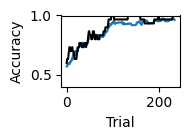

*** Starting subject 32/61 (sub535) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.15 min |Max net perf: 0.88 | min LS: 0.69 | best fit: 0.094, 0.010, 0.010


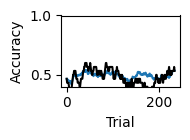

*** Starting subject 33/61 (sub536) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.27 min |Max net perf: 0.88 | min LS: 1.45 | best fit: 0.057, 0.384, 1.879


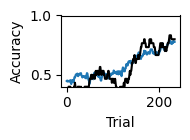

*** Starting subject 34/61 (sub537) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.59 min |Max net perf: 0.86 | min LS: 3.13 | best fit: 0.020, 0.384, 1.505


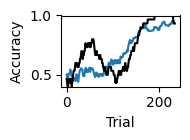

*** Starting subject 35/61 (sub538) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.88 | min LS: 0.60 | best fit: 0.094, 2.252, 0.384


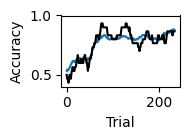

*** Starting subject 36/61 (sub539) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.44 min |Max net perf: 0.87 | min LS: 1.28 | best fit: 0.131, 2.252, 0.010


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


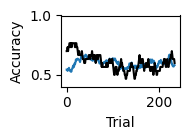

*** Starting subject 37/61 (sub540) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.32 min |Max net perf: 0.86 | min LS: 0.59 | best fit: 0.020, 1.879, 1.505


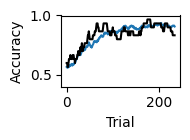

*** Starting subject 38/61 (sub541) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.10 min |Max net perf: 0.88 | min LS: 0.52 | best fit: 0.075, 2.626, 1.131


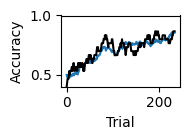

*** Starting subject 39/61 (sub542) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.43 min |Max net perf: 0.88 | min LS: 1.59 | best fit: 0.057, 0.758, 0.384


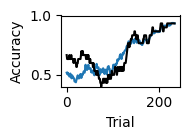

*** Starting subject 40/61 (sub543) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.35 min |Max net perf: 0.86 | min LS: 3.03 | best fit: 0.001, 0.010, 0.010


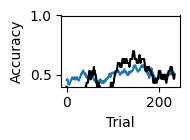

*** Starting subject 41/61 (sub544) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.35 min |Max net perf: 0.88 | min LS: 0.42 | best fit: 0.094, 0.758, 1.131


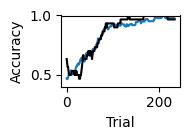

*** Starting subject 42/61 (sub545) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.42 min |Max net perf: 0.88 | min LS: 0.50 | best fit: 0.113, 2.252, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


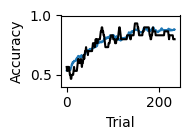

*** Starting subject 43/61 (sub546) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.41 min |Max net perf: 0.86 | min LS: 2.21 | best fit: 0.057, 1.879, 0.758


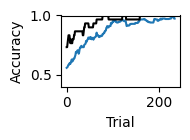

*** Starting subject 44/61 (sub547) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.42 min |Max net perf: 0.88 | min LS: 0.71 | best fit: 0.075, 2.252, 0.384


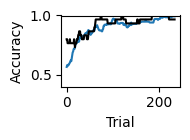

*** Starting subject 45/61 (sub548) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.88 | min LS: 0.89 | best fit: 0.094, 2.252, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


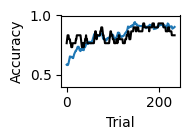

*** Starting subject 46/61 (sub549) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.88 | min LS: 0.97 | best fit: 0.038, 2.626, 0.758


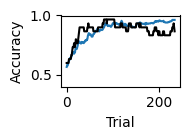

*** Starting subject 47/61 (sub550) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.40 min |Max net perf: 0.88 | min LS: 0.83 | best fit: 0.150, 2.626, 0.384


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


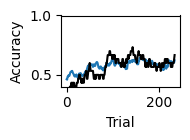

*** Starting subject 48/61 (sub551) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.41 min |Max net perf: 0.87 | min LS: 1.86 | best fit: 0.038, 3.000, 0.010


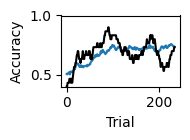

*** Starting subject 49/61 (sub552) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.87 | min LS: 2.00 | best fit: 0.131, 1.879, 0.384


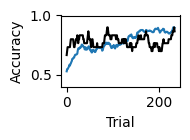

*** Starting subject 50/61 (sub553) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.87 | min LS: 1.46 | best fit: 0.131, 0.758, 0.758


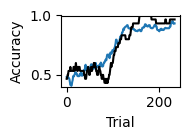

*** Starting subject 51/61 (sub554) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.40 min |Max net perf: 0.87 | min LS: 4.37 | best fit: 0.057, 1.505, 0.758


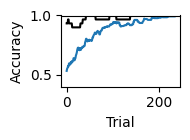

*** Starting subject 52/61 (sub555) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.88 | min LS: 0.46 | best fit: 0.094, 1.505, 0.758


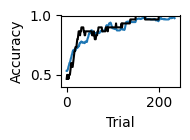

*** Starting subject 53/61 (sub556) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.41 min |Max net perf: 0.88 | min LS: 0.91 | best fit: 0.057, 2.626, 2.252


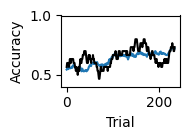

*** Starting subject 54/61 (sub557) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.33 min |Max net perf: 0.88 | min LS: 0.97 | best fit: 0.094, 0.384, 0.758


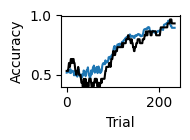

*** Starting subject 55/61 (sub558) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.38 min |Max net perf: 0.87 | min LS: 0.49 | best fit: 0.057, 1.879, 0.384


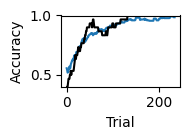

*** Starting subject 56/61 (sub559) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.34 min |Max net perf: 0.87 | min LS: 1.33 | best fit: 0.038, 2.252, 0.758


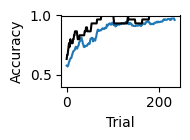

*** Starting subject 57/61 (sub560) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.35 min |Max net perf: 0.88 | min LS: 1.35 | best fit: 0.057, 3.000, 1.131


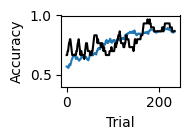

*** Starting subject 58/61 (sub561) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.87 | min LS: 0.42 | best fit: 0.113, 1.505, 0.384


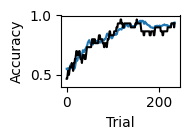

*** Starting subject 59/61 (sub562) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.39 min |Max net perf: 0.88 | min LS: 1.11 | best fit: 0.094, 3.000, 1.131


/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nicholasschuck/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


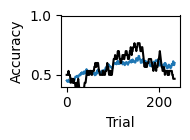

*** Starting subject 60/61 (sub563) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.37 min |Max net perf: 0.85 | min LS: 0.55 | best fit: 0.038, 2.252, 0.758


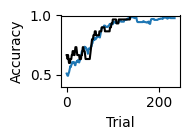

*** Starting subject 61/61 (sub564) ***
11% |22% |33% |44% |56% |67% |78% |89% |100% | => Finished!
Time elapsed: 11.38 min |Max net perf: 0.88 | min LS: 0.72 | best fit: 0.113, 1.131, 0.758


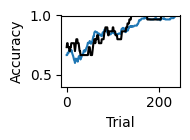

Text(0, 0.5, 'Accuracy')

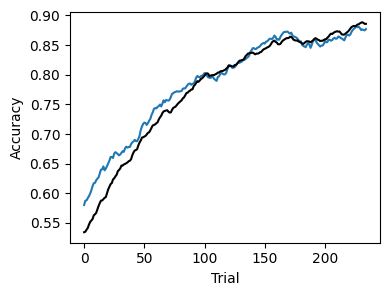

In [14]:
# Loop over subjects
for subj_idx, csub in enumerate(subjs):
    print(f"*** Starting subject {subj_idx+1}/{n_subj} ({csub}) ***") 
    start_time = time.time()  # Star
    (inputs, 
    active_inputs, 
    passive_inputs, 
    targets, 
    active_targets, 
    passive_targets, 
    states, 
    isPassive, 
    block, 
    passive_type, 
    responses, 
    correct_responses) = prepare_data(csub, csvpath, isRecurrent=True, withPassive=True, input_norm = input_norm)
    passive_idx = np.where(isPassive)[0]
    responses_num = np.array([response_mapping.get(response, -1) for response in responses])  # Default to -1 for unexpected values
    target_nodes = np.argmax(targets, axis=1)
    csubjcorrect = (target_nodes.numpy().flatten() == responses_num)
    choiceacc_array[subj_idx, :] = csubjcorrect[isPassive == 0]  # Store choice accuracy for active trials
    
    
    passive_inputs_outs[:, :, :, subj_idx] = passive_inputs[0,:,stepidx[0,:],:]

    earlypre_sort_matrix, earlypost_sort_matrix, latepre_sort_matrix, latepost_sort_matrix, latepre_repeat_sort_matrix, latepost_repeat_sort_matrix = get_pair_indices(states, passive_idx)
    for lr_idx, learning_rate in enumerate(learning_rates):
        #print(f"  Starting loop for learning_rate: {learning_rate}")
        for g_idx, rnn_gain in enumerate(rnn_gains):
            for fg_idx, fc_gain in enumerate(fc_gains):
                closses = np.full((n_active_trials, n_iter), np.nan); caccuracies = np.full((n_active_trials, n_iter), np.nan);  
                crewards = np.full((n_active_trials, n_iter), np.nan); cpes = np.full((n_active_trials, n_iter), np.nan); 
                cprobs = np.full((n_active_trials, n_iter), np.nan);  csubjcorrect = np.full((n_active_trials, n_iter), np.nan); 
                cweights = np.full((10, n_active_trials, n_iter), np.nan); 
                for citer in range(n_iter):
                    passive_index = 0; active_index = 0   
                    model = SimpleRNN(
                        input_dim=input_dim,
                        hidden_rnn_dim=hidden_rnn_dim,
                        hidden_fc_dim=hidden_fc_dim,
                        output_dim=output_dim,
                        hidden_rnn_activation=hidden_rnn_activation,
                        hidden_fc_activation=hidden_fc_activation,
                        output_activation=output_activation,
                        layer_norm=layer_norm
                        )
                    model.apply(lambda module: initialize_weights(module, 
                        rnn_gain=rnn_gain, 
                        fc_gain=fc_gain, 
                        weight_init=weight_init, 
                        rnn_nonlinearity=hidden_rnn_activation, 
                        fc_nonlinearity=hidden_fc_activation))
                    criterion = nn.SmoothL1Loss() # MSE? 
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
                    model.train() 
                    for ctrial in range(n_trials):
                        optimizer.zero_grad()
                        trial_input = inputs[:, :, :, ctrial]
                        outputs = []
                        if isPassive[ctrial] == 1:
                            if citer == (n_iter-1):  # Only store the last iteration's outputs
                                ctrial_input = trial_input[:, :, stepidx[0, :]]
                                output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                                passive_rnn_last_outs[passive_index, :, lr_idx, g_idx, fg_idx, subj_idx] = rnn_last_out.detach().cpu().numpy()
                                passive_fc_hidden_outs[passive_index, :, lr_idx, g_idx, fg_idx, subj_idx] = fc_hidden_out.detach().cpu().numpy()
                                passive_index += 1
                        else:
                            for cstep in range(2):
                                ctrial_input = trial_input[:, :, stepidx[cstep, :]]
                                output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                                outputs.append(output)
                            trial_target = targets[:, :, ctrial]
                            target_node = target_nodes[0, ctrial]
                            outputs_tensor = torch.stack(outputs)
                            predicted_node = torch.argmax(outputs_tensor, dim=0).item()
                            participant_choice = responses_num[ctrial]
                            #participant_correct = (responses_num[ctrial] == target_node).item()
                            
                            probabilities = F.softmax(outputs_tensor/0.66, dim=0)
                            prob_max = probabilities[predicted_node].item() # type: ignore
                            prob_choice = probabilities[participant_choice].item() if participant_choice in [0, 1] else np.nan
                            #print(prob)

                            ctrial_input = trial_input[:, :, stepidx[predicted_node]] # type: ignore
                            output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                            reward = trial_target[0, predicted_node] # type: ignore
                            target_value = trial_target[:, predicted_node].unsqueeze(1) # type: ignore
                            #print(output-target_value)
                            loss = criterion(output, target_value)
                            loss.backward()
                            optimizer.step()
                            avg_weights = get_avg_input_weights(model)
                            cweights[:, active_index, citer] = avg_weights.detach().cpu().numpy()
                            closses[active_index, citer] = loss.item()
                            cprobs[active_index, citer] = prob_choice
                            crewards[active_index, citer] = reward.item()
                            caccuracies[active_index, citer] = (predicted_node == target_node).item()
                            cpes[active_index, citer] = np.abs((output.item()-target_value.item()))
                            active_index +=1

                # Store results
                loss_array[lr_idx, g_idx, fg_idx, subj_idx, :] = np.mean(closses, axis = 1)
                acc_array[lr_idx, g_idx, fg_idx, subj_idx, :] = np.mean(caccuracies, axis = 1)
                rewards_array[lr_idx, g_idx, fg_idx, subj_idx, :] = np.mean(crewards, axis = 1)
                pes_array[lr_idx, g_idx, fg_idx, subj_idx, :] = np.mean(cpes, axis = 1)
                weights_array[lr_idx, g_idx, fg_idx, subj_idx, :, :] = np.mean(cweights, axis = 2)
                # negative log likelihood 
                nll_array[lr_idx, g_idx, fg_idx, subj_idx, :] = -np.log(np.clip(np.mean(cprobs, axis = 1), 1e-5, 1 - 1e-5))
        cpercent = 100 * (lr_idx + 1) / n_lr
        print(f"{cpercent:.0f}%", end=" |")
    print(f" => Finished!")
    elapsed = time.time() - start_time
    print(f"Time elapsed: {elapsed/60:.2f} min", end=" |")
    # get max average over trials (last dimension) for current subject
    cdata = acc_array[:, :, :, subj_idx, :]
    reshaped_data = cdata.reshape(-1, n_active_trials)  # Reshape to (n_lr * n_rg * n_fg, n_active_trials)
    # Apply running_average to each row
    smoothed_data = np.array([running_average(reshaped_data[i,:], window_size = win_size) for i in range(reshaped_data.shape[0])])
    smoothed_behavior = running_average(choiceacc_array[subj_idx, :]*1, window_size = win_size)
    LS = np.sum((smoothed_data[:,:] - smoothed_behavior[:])**2, axis=1)
    cidx = np.argmin(LS)
    i, j, k = np.unravel_index(cidx, (n_lr, n_rg, n_fg))
    mean_acc_current_subj = np.nanmean(cdata, axis=-1)  # Shape: (n_lr, n_rg, n_fg)
    max_acc = np.nanmax(mean_acc_current_subj)
    
    best_subj_net[:,subj_idx] = [i, j, k]#np.unravel_index(np.argmin(sum_prob[:, :, :, subj_idx]), sum_prob[:, :, :, subj_idx].shape)
    net_perf[subj_idx, :] = smoothed_data[cidx,:]
    subj_perf[subj_idx, :] = smoothed_behavior 
    subj_weights[subj_idx, :, :] = weights_array[best_subj_net[0,subj_idx], best_subj_net[1,subj_idx], best_subj_net[2,subj_idx], subj_idx, :, :] 
    
    # compute state correlation matrix
    rnnreps = passive_rnn_last_outs[:, :, i, j, k, subj_idx]
    fcreps = passive_fc_hidden_outs[:, :, i, j, k, subj_idx]
    inputs = np.transpose(np.sum(passive_inputs_outs[:, :, :, subj_idx], axis = 0))
    state_corr_rnn_all[:, :, :, subj_idx] = compute_state_corr_mat(rnnreps, states, passive_idx, all_states=all_states, n_blocks=n_blocks, blocksize=blocksize)
    state_corr_fc_all[:, :, :, subj_idx] = compute_state_corr_mat(fcreps, states, passive_idx, all_states=all_states, n_blocks=n_blocks, blocksize=blocksize)
    input_corr_all[:, :, :, subj_idx] = compute_state_corr_mat(inputs, states, passive_idx, all_states=all_states, n_blocks=n_blocks, blocksize=blocksize)
    
    print(f"Max net perf: {max_acc:.2f} | min LS: {np.nanmin(LS):.2f} | best fit: {learning_rates[i]:.3f}, {rnn_gains[j]:.3f}, {fc_gains[k]:.3f}")
    
    plt.figure(figsize=(2, 1.5))  # Small size: width=4, height=3 inches
    plt.plot(smoothed_data[cidx, :], linewidth=1.5)
    plt.plot(smoothed_behavior, color='black', linewidth=1.5)
    plt.xlabel("Trial", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.ylim(0.4, 1) 
    plt.tight_layout()  # Removes extra whitespace
    plt.show()

plt.figure(figsize=(4, 3))
#plt.subplot(1, 2, 1)
plt.plot(np.nanmean(subj_perf, axis = 0), linewidth = 1.5) 
plt.plot(np.nanmean(net_perf, axis = 0), color = 'black', linewidth = 1.5) 
plt.xlabel("Trial")
plt.ylabel("Accuracy")


In [ ]:
# Save all major arrays after the training loop completes
import pickle


# Create a dictionary with all the major arrays
results_data = {
    # Main performance arrays
    'loss_array': loss_array,           # Shape: (n_lr, n_rg, n_fg, n_subj, n_active_trials)
    'acc_array': acc_array,             # Shape: (n_lr, n_rg, n_fg, n_subj, n_active_trials)
    'rewards_array': rewards_array,     # Shape: (n_lr, n_rg, n_fg, n_subj, n_active_trials)
    'pes_array': pes_array,             # Shape: (n_lr, n_rg, n_fg, n_subj, n_active_trials)
    'nll_array': nll_array,             # Shape: (n_lr, n_rg, n_fg, n_subj, n_active_trials)
    
    # Weight arrays
    'weights_array': weights_array,     # Shape: (n_lr, n_rg, n_fg, n_subj, 10, n_active_trials)
    'subj_weights': subj_weights,       # Shape: (n_subj, 10, n_active_trials)
    
    # Neural representations
    'passive_rnn_last_outs': passive_rnn_last_outs,     # Shape: (n_passive_trials, hidden_rnn_dim, n_lr, n_rg, n_fg, n_subj)
    'passive_fc_hidden_outs': passive_fc_hidden_outs,   # Shape: (n_passive_trials, hidden_fc_dim, n_lr, n_rg, n_fg, n_subj)
    'passive_inputs_outs': passive_inputs_outs,         # Shape: (n_steps, input_dim, n_passive_trials, n_subj)
    
    # Best network parameters and performance
    'best_subj_net': best_subj_net,     # Shape: (3, n_subj) - indices of best lr, rnn_gain, fc_gain per subject
    'net_perf': net_perf,               # Shape: (n_subj, 235) - smoothed network performance
    'subj_perf': subj_perf,             # Shape: (n_subj, 235) - smoothed subject behavior
    'choiceacc_array': choiceacc_array, # Shape: (n_subj, n_active_trials) - subject choice accuracy
    
    # Correlation matrices
    'state_corr_rnn_all': state_corr_rnn_all,   # Shape: (8, 8, n_blocks, n_subj)
    'state_corr_fc_all': state_corr_fc_all,     # Shape: (8, 8, n_blocks, n_subj)
    'input_corr_all': input_corr_all,           # Shape: (8, 8, n_blocks, n_subj)
    
    # Experimental parameters for reference
    'learning_rates': learning_rates,
    'rnn_gains': rnn_gains,
    'fc_gains': fc_gains,
    'subjs': subjs,
    'all_states': all_states,
    'n_lr': n_lr,
    'n_rg': n_rg,
    'n_fg': n_fg,
    'n_subj': n_subj,
    'n_blocks': n_blocks,
    'n_active_trials': n_active_trials,
    'n_passive_trials': n_passive_trials
}

# Save using pickle
with open('~/data/state-formation/neural_network_results.pkl', 'wb') as f:
    pickle.dump(results_data, f)


In [ ]:
input_corr_mat = np.full((8, 8, n_blocks, n_subj), np.nan)
early_pre_corr_mat = np.full((4, 4, n_blocks, n_subj), np.nan)
early_change_corr_mat = np.full((4, 4, n_blocks, n_subj), np.nan)
late_pre_corr_mat = np.full((4, 4, n_blocks, n_subj), np.nan)
late_change_corr_mat = np.full((4, 4, n_blocks, n_subj), np.nan)

fig, axes = plt.subplots(2, int((n_subj+1)/2), figsize=(20, 4))
axes = axes.flatten()

for subj_idx, csub in enumerate(subjs):    
    (inputs, 
    active_inputs, 
    passive_inputs, 
    targets, 
    active_targets, 
    passive_targets, 
    states, 
    isPassive, 
    block, 
    passive_type, 
    responses, 
    correct_responses) = prepare_data(csub, csvpath, isRecurrent=True, withPassive=True)
    
    passive_idx = np.where(isPassive)[0]
    
    (earlypre_sort_matrix, 
    earlypost_sort_matrix, 
    latepre_sort_matrix, 
    latepost_sort_matrix, 
    latepre_repeat_sort_matrix, 
    latepost_repeat_sort_matrix) = get_pair_indices(states, passive_idx)
    # passive_fc_hidden_outs
    passive_rnn_last_outs_array = passive_rnn_last_outs[:, :, best_subj_net[0,subj_idx], best_subj_net[1,subj_idx], best_subj_net[2,subj_idx], subj_idx]
    passive_fc_hidden_outs_array = passive_fc_hidden_outs[:, :, best_subj_net[0,subj_idx], best_subj_net[1,subj_idx], best_subj_net[2,subj_idx], subj_idx]
    netreps =   passive_fc_hidden_outs_array#passive_rnn_last_outs_array #
    pca = PCA(n_components=3)
    rep_redux = pca.fit_transform(netreps)
    factors = states[isPassive == True]
    first_letters = np.array([fac[0] for fac in factors])
    ax = axes[subj_idx]
    alpha_values = 0.1 + 0.9 * (np.arange(n_passive_trials) / n_passive_trials)  # Create alpha values from 0.1 to 1.0
    for factor in np.unique(first_letters):
        mask = np.array(first_letters) == factor
        ax.scatter(rep_redux[mask, 0], rep_redux[mask, 1], 
                   label=factor, 
                   alpha=alpha_values[mask], s=10)  # Use alpha values for transparency
    
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    #ax.set_title(np.mean(subj_perf[subj_idx, :]))
    
    for cblock in np.arange(n_blocks):
        ctrials = np.arange(cblock*42, (cblock+1)*42)
        for ct1, cstate1 in enumerate(all_states): 
                cstatevec = np.where(states == cstate1)[0]
                cidx1 = cstatevec[np.isin(cstatevec, ctrials)]
                cidx1 = np.where(np.isin(passive_idx, cidx1))[0]
                A = np.nanmean(netreps[cidx1, :], axis = 0) 
                Ai = np.nanmean(passive_inputs_outs[:, :, cidx1, subj_idx], axis = (0, 2))  
                for ct2, cstate2 in enumerate(all_states):
                        cstatevec = np.where(states == cstate2)[0]
                        cidx2 = cstatevec[np.isin(cstatevec, ctrials)]
                        cidx2 = np.where(np.isin(passive_idx, cidx2))[0]
                        B = np.nanmean(netreps[cidx2, :], axis = 0) 
                        Bi = np.nanmean(passive_inputs_outs[:, :, cidx2, subj_idx], axis = (0, 2))
                        state_corr_mat[ct1, ct2, cblock, subj_idx] = np.corrcoef(A, B)[0,1]  
                        input_corr_mat[ct1, ct2, cblock, subj_idx] = np.corrcoef(Ai, Bi)[0,1]  

        early_change = netreps[earlypre_sort_matrix[cblock,:], :] - netreps[earlypost_sort_matrix[cblock,:], :]
        late_change = netreps[latepre_sort_matrix[cblock,:], :] - netreps[latepost_sort_matrix[cblock,:], :]
        early_pre_corr_mat[:, :, cblock, subj_idx] = np.corrcoef(np.corrcoef(netreps[earlypre_sort_matrix[cblock,:], :]))
        early_change_corr_mat[:, :, cblock, subj_idx] = np.corrcoef(early_change)
        late_pre_corr_mat[:, :, cblock, subj_idx] = np.corrcoef(np.corrcoef(netreps[latepre_sort_matrix[cblock,:], :]))
        late_change_corr_mat[:, :, cblock, subj_idx] = np.corrcoef(late_change)

mean_state_corr = np.nanmean(state_corr_mat[:, :, 1:11,:], axis=(2, 3))  # shape (8, 8)
mean_input_corr = np.nanmean(input_corr_mat, axis=(2, 3))  # shape (8, 8)

# (1) Top-left quadrant (4x4), excluding diagonal
within_state = mean_state_corr[:4, :4]
within_input = mean_input_corr[:4, :4]
between_state = mean_state_corr[4:8, :4]
between_input = mean_input_corr[4:8, :4]
# Exclude diagonal
mask = ~np.eye(4, dtype=bool)

print("Mean state corr within:", np.mean(within_state[mask]))
print("Mean state corr between:", np.mean(between_state[mask]))
print("Mean input corr within:", np.mean(within_input[mask]))
print("Mean input corr between:", np.mean(between_input[mask]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean_state_corr on the left subplot
im1 = ax1.imshow(mean_state_corr, vmin=-0.5, vmax=1, cmap='viridis')
ax1.set_title("State Correlation Matrix (mean)")
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Correlation')
cbar1.set_ticks([-0.5, 0.0, 0.25, 0.5, 0.75, 1.0])

# Plot mean_input_corr on the right subplot
im2 = ax2.imshow(mean_input_corr, vmin=-0.5, vmax=1, cmap='viridis')
ax2.set_title("Input Correlation Matrix (mean)")
cbar2 = plt.colorbar(im2, ax=ax2)







In [ ]:

mean_within = 0.25*(early_change_corr_mat[0, 1, :, :] + early_change_corr_mat[2, 3, :, :] + 
                    late_change_corr_mat[0, 1, :, :] + late_change_corr_mat[2, 3, :, :])#np.mean(np.stack([vals_12_34, vals_34_34], axis=0), axis=0)  # shape (11,)
# Indices for (1,3), (1,4), (2,3), (2,4): [0,2], [0,3], [1,2], [1,3]
e_13 = early_change_corr_mat[0, 2, :, :]
e_14 = early_change_corr_mat[0, 3, :, :]
e_23 = early_change_corr_mat[1, 2, :, :]
e_24 = early_change_corr_mat[1, 3, :, :]
l_13 = late_change_corr_mat[0, 2, :, :]
l_14 = late_change_corr_mat[0, 3, :, :]
l_23 = late_change_corr_mat[1, 2, :, :]
l_24 = late_change_corr_mat[1, 3, :, :]
mean_between = np.nanmean(np.stack([e_13, e_14, e_23, e_24, l_13, l_14, l_23, l_24], axis=0), axis=0)  # shape (11,)

lower_indices = np.tril_indices(4, k = -1)  # Gets indices for 4x4 lower triangle
correlations = [np.corrcoef(early_change_corr_mat[lower_indices][:, i], early_pre_corr_mat[lower_indices][:, i])[0, 1] for i in range(11)]

print('State-Change Correlations', np.nanmean(correlations))
print("Mean WITHIN context", np.nanmean(mean_within))
print("Mean BETWEEN context", np.nanmean(mean_between))
plt.plot(np.nanmean(mean_within, axis = 1), color = 'black')
plt.plot(np.nanmean(mean_between, axis = 1), color = 'blue')
plt.show()
plt.plot(np.nanmean(mean_within-mean_between, axis = 1), color = 'black')
plt.show()
print(mean_within.shape)  
print(mean_between.shape)    
        



In [ ]:
A = np.random.rand(4, 4, 11)

lower_values = A[lower_indices]  # Shape will be (10, 11) - 10 values per matrix
#print(A)  # (10, 11)
print(lower_indices)  # (10, 11)
print(lower_values.shape)

In [ ]:

# plotting 
best_net_acc = np.nanmean(acc_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
best_net_loss = np.nanmean(loss_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
best_net_acc_s = running_average(best_net_acc, window_size=15)
best_net_loss_s = running_average(best_net_loss, window_size=15)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_net_acc_s)
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title(f'Best performing net: alpha {learning_rates[max_indices[0]]} RNN gain: {rnn_gains[max_indices[1]]}')

plt.subplot(1, 2, 2)
plt.plot(best_net_loss_s)
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title(f'Best performing net: alpha {learning_rates[max_indices[0]]} RNN gain: {rnn_gains[max_indices[1]]}')

# plot best fitting per subject 
plt.figure(figsize=(12, 6))

for subj_idx, csub in enumerate(subjs):
    best_net_acc = np.nanmean(acc_array[best_subj_net[0,subj_idx], best_subj_net[1,subj_idx], best_subj_net[2,subj_idx], :,:], axis=(0))
    best_net_acc_s = running_average(best_net_acc, window_size=30)
    subj_acc_s = running_average(results["subjcorrect"][csub], window_size=30) 
    plt.subplot(2, int(n_subj/2), subj_idx+1)
    plt.plot(best_net_acc_s)
    plt.plot(subj_acc_s)
    plt.ylim(0.25, 1)
    plt.xlabel("Trial")
    plt.ylabel("Accuracy")
    plt.title(f'subj {csub}')
    
    

### Plot best fitting networks

### Run network with different learning rates / gains etc for subset of subjs and stroe results 

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(passive_rnn_last_outs[:, :, 0, 1, 1, 0], aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Vector Dimensions')
plt.ylabel('Trial Index')
plt.title('Visualization of Passive RNN Last Outputs')
plt.show()
passive_index

# Map each response individually

#print(responses)
print(responses_num)


In [ ]:
passive_states = np.array(states[isPassive == 1])  # Get states for passive trials
# passive_fc_hidden_outs
passive_rnn_last_outs_array = passive_rnn_last_outs[:, :, lr_idx-1, g_idx-1, fg_idx-2, 0]
all_states = np.unique(passive_states)
correlations_by_label = np.zeros((len(all_states), len(all_states)))  # Preallocate array for correlations
# Iterate over all unique labels

for lidx1, label1 in enumerate(all_states): 
    # Get indices of vectors with the current label
    label_indices1 = np.where(passive_states == label1)[0]
    vectors1 = passive_rnn_last_outs_array[label_indices1, :]
    for lidx2, label2 in enumerate(all_states):
        # Get indices of vectors with the current label
        label_indices2 = np.where(passive_states == label2)[0]

        # Extract the corresponding vectors
        vectors2 = passive_rnn_last_outs_array[label_indices2, :]
        #print(vectors.shape)
    
        # Compute pairwise correlations
        correlation_matrix = np.corrcoef(vectors1, vectors2, rowvar=True)  # Correlation matrix
        correlations_by_label[lidx1, lidx2] = np.nanmean(correlation_matrix)

#correlations_by_label['b1_l']

plt.figure(figsize=(10, 6))
plt.imshow(correlations_by_label, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Vector Dimensions')
plt.ylabel('Trial Index')
plt.title('Visualization of Passive RNN Last Outputs')
plt.show()

print(states)

In [ ]:
print(results["pes"][csub][learning_rate][rnn_gain][fc_gain])

### Find best Network and plot avg performance 

### Plot color map of net performance over param space 

In [ ]:
cmap = np.nanmean(acc_array[:, :, :, :, 200:n_trials], axis=(2,3,4))
plt.figure(figsize=(12, 6))
plt.imshow(cmap, cmap='viridis', aspect='auto')
plt.colorbar(label='Mean Loss')
print(cmap)


### plot marginal learning curves to see variation in params 

In [ ]:

mar_dim_names = ['alpha', 'r_gain', 'f_gain']  # Convert to a list for indexing
# Plot the running averages
plt.figure(figsize=(18, 6))

for cdim in range(3):
    running_avg_loss, running_avg_accuracy, dimsize = prep_marginal_means(cdim = cdim, loss_array=loss_array, acc_array=acc_array, window_size=15)
    plt.subplot(1, 3, cdim+1)
    colors = cm.viridis(np.linspace(0, 1, n_lr))  # Generate a continuous color scale
    for idx in range(dimsize):
        plt.plot(running_avg_accuracy[idx, :], label=f"{mar_dim_names[cdim]}={learning_rates[idx]:.1e}", color=colors[idx])
        plt.legend()
        plt.xlabel("Trial")
        plt.ylabel("Accuracy")
        plt.title(f"Marginal Learning Curves {mar_dim_names[cdim]}")

plt.show()

